<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/keras_tutorial_rnn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for regression with RNN

Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, BatchNormalization, Activation, Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import SVG

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


2.2.0-rc2


In [2]:
#check GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Create data

In [0]:
def sin(x, T):
    return np.sin(2.0 * np.pi * x / T)

In [0]:
def generate_data(T, A=0.01):
    x = np.arange(0, 2 * T + 1)
    noise = A * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x, T) + noise

In [0]:
def load_data(T, maxlen):
    data = generate_data(T)

    X, y = [], []
    for i in range(len(data)-maxlen):
        X.append(data[i:i + maxlen])
        y.append(data[i + maxlen])

    X = np.array(X).reshape(len(X), maxlen, 1)
    y = np.array(y).reshape(len(X), 1)

    return X, y

In [0]:
# read the dataset
data_size = 100
maxlen = 30
X_train, y_train = load_data(data_size, maxlen)
X_test, y_test = load_data(data_size, maxlen)

In [64]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

171 171
171 171


###Train model

In [0]:
def build_model(RNNtype):
  activation = 'tanh'
  h_nodes = 100
  if RNNtype == 'Simple':
    RNNcell = SimpleRNN(h_nodes, activation=activation, input_shape=(maxlen, X_train.shape[2]))
  elif RNNtype == 'LSTM':
    RNNcell = LSTM(h_nodes, activation=activation, input_shape=(maxlen, X_train.shape[2]))
  elif RNNtype == 'GRU':
    RNNcell = GRU(h_nodes, activation=activation, input_shape=(maxlen, X_train.shape[2]))

  model = Sequential([
    #Embedding(input_dim=max_features, output_dim=100, input_length=maxlen, embeddings_initializer='glorot_uniform'),
    RNNcell,
    Dense(1, activation='linear')
  ], name='model_'+RNNtype)

  #compile
  loss = 'mean_squared_error'
  optimizer = SGD(lr=0.01, nesterov=True)
  model.compile(loss=loss, optimizer=optimizer)

  return model

In [0]:
models = {'Simple' : build_model('Simple'),
                'LSTM' : build_model('LSTM'),
                'GRU' : build_model('GRU')}

In [51]:
for key in models:
  models[key].summary()

Model: "model_Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________
Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Model: "model_GRU"
_______

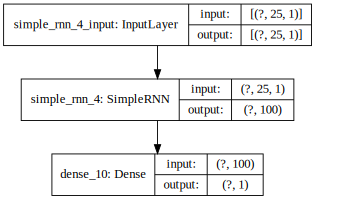

In [52]:
SVG(model_to_dot(models['Simple'], show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
!mkdir log

In [0]:
callbacks = [#EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), #stop training if there is no improvement
                   ModelCheckpoint('./log/model_{epoch:03d}_{val_loss:.4f}.h5', save_best_only=True) #save models
                   ]

In [67]:
histories = dict()
for key in models:
  histories[key] = models[key].fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 0s 174ms/step - loss: 0.0779 - val_loss: 0.0326
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0325 - val_loss: 0.0387
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0386 - val_loss: 0.0444
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0444 - val_loss: 0.0364
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0362 - val_loss: 0.0192
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0192 - val_loss: 0.0090
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0089 - val_loss: 0.0051
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/100
1/1 [

In [0]:
def plot_loss(history):
  plt.figure(figsize=(6, 4))

  plt.plot(history.epoch, history.history["loss"], label="train_loss")
  plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
  plt.xlabel("epoch")
  plt.legend()

Simple
LSTM
GRU


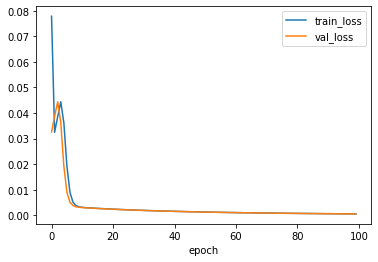

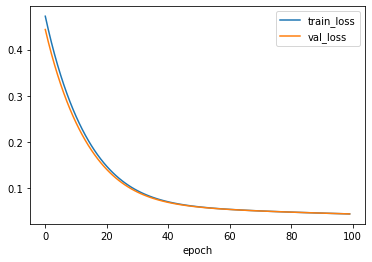

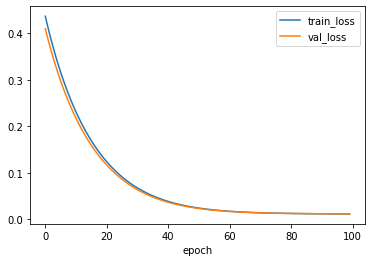

In [68]:
for key in histories:
  print(key)
  plot_loss(histories[key])

###Test

In [69]:
model = models['Simple']
test_loss = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 5ms/step - loss: 5.1051e-04


In [70]:
print('test loss : ', test_loss)

test loss :  0.0005105105228722095


In [0]:
y_test_pred = model.predict(X_test)

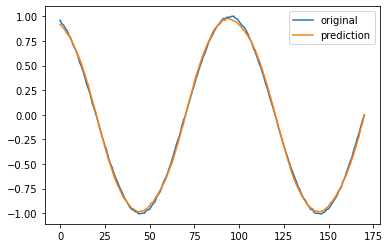

In [72]:
plt.plot(np.arange(len(y_test)), y_test, label='original')
plt.plot(np.arange(len(y_test)), y_test_pred, label='prediction')
plt.legend()
plt.show()

###Save

In [0]:
#save the prediction
submissiondir = '.'
submissionname = 'submission'
pd.DataFrame(data={'x':np.arange(len(y_test)), 'target':y_test[:,0], 'prediction':y_test_pred[:,0]}).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=["Id"])

In [0]:
# save the model
filename = 'model.h5'
model.save(filename)

In [76]:
# load the model
loaded_model = load_model(filename)
test_loss = loaded_model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 4ms/step - loss: 5.1051e-04


In [77]:
print('test loss : ', test_loss)

test loss :  0.0005105105228722095
